# Exercise 3: Transfer Learning
The filters learned by convolutional neural networks are fairly generic.
Below is an image that matches one of the filters of a CNN trained on ImageNet (a database of labeled photographs).
<center><img src="https://blog.keras.io/img/conv5_1_filter_0.png"/></center>

This filter represents a certain pattern that, if present in an image, helps identify what that image might be. 
As you can see, it is hardly possible to identify what this pattern would actually correspond to. 
What scientists have found is that these learned filters can be used as good starting points for other problems, even [materials science](http://arxiv.org/abs/1711.00404).
The process of reusing state learned from a previous task is called "Transfer Learning" and is the focus of this notebook.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from keras.applications import ResNet50
from keras.datasets import cifar10
from keras.models import Model
from keras import layers
import pandas as pd
import numpy as np
import keras

Using TensorFlow backend.


Configuration

In [2]:
batch_size = 128
epochs = 8
subset_frac = 0.1

## Load in Data
We are going to use the [CIFAR 10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset again for this notebook.

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

As before, we need to convert the labels into a binary representation and images into a floating point number

In [4]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

To better illustrate the effects of transfer learning, we are going to take only 10% of the training data.

In [6]:
x_train_subset, _, y_train_subset, _ = train_test_split(x_train, y_train, train_size=subset_frac)

In [7]:
x_train_subset.shape

(5000, 32, 32, 3)

## Loading a Pre-Made Model
We are going to try out the [ResNet](https://arxiv.org/abs/1512.03385), a image classification network presented in 2015.
ResNet features "residual connections" hat allow it to benefit from very a large number of layers. 
[ResNet50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) has 50 layers!

You can load the architecture directly from Keras with randomly initialized weights and have Keras automatically make the right input and output shapes.

In [8]:
random_start = ResNet50(weights=None, input_shape=x_train.shape[1:], classes=10)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
random_start.input_shape

(None, 32, 32, 3)

In [10]:
random_start.output_shape

(None, 10)

You can also load the weights of this model trained on the [ImageNet dataset](http://www.image-net.org).

In [11]:
pretrained = ResNet50(weights='imagenet', include_top=False, input_shape=x_train.shape[1:])

/home/lward/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [12]:
pretrained.input_shape

(None, 32, 32, 3)

In [13]:
pretrained.output_shape

(None, 1, 1, 2048)

Note that the pretrained model does not have the right number of output layers. So, we need add a Flatten layer and a Dense output to get the correct (N, 10) output shape

Note: We are going to use Keras's [functional API](https://keras.io/models/model/), where you express new layers as functions acting on previous layers.

In [14]:
flattened = layers.Flatten()(pretrained.output)

In [15]:
output = layers.Dense(10, activation='softmax')(flattened)

In [16]:
pretrained = Model(pretrained.inputs, output)

In [17]:
pretrained.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [18]:
pretrained.output_shape

(None, 10)

Storing the initial weights of the models

In [19]:
def get_weights_resnet(model):
    layer_weights = []
    for i, l in enumerate(model.layers):
        if isinstance(l, (layers.Conv2D, layers.Dense)):
            layer_weights.append({
                'layer': i,
                'weights': l.get_weights()[0]
            })
    return pd.DataFrame(layer_weights)

In [20]:
pretrained_start = get_weights_resnet(pretrained)

In [21]:
random_weights_start = get_weights_resnet(random_start)

## Comparing the Pre-Trained vs Non-Pretrained Models
We will train each model a few epochs and see how well they do on the training set and test set

In [22]:
pretrained.compile(RMSprop(lr=1e-3), 'categorical_crossentropy', metrics=['acc'])

In [23]:
pretrained.input_shape

(None, 32, 32, 3)

In [24]:
pretrained_history = pretrained.fit(x_train_subset, y_train_subset, validation_split=0.1,
                                    batch_size=batch_size, epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Train on 4500 samples, validate on 500 samples
Epoch 1/8
4500/4500 [==============================] - 41s 9ms/step - loss: 2.3996 - acc: 0.3458 - val_loss: 3.5660 - val_acc: 0.2440
Epoch 2/8
4500/4500 [==============================] - 22s 5ms/step - loss: 1.7673 - acc: 0.4627 - val_loss: 14.1195 - val_acc: 0.1240
Epoch 3/8
4500/4500 [==============================] - 20s 5ms/step - loss: 1.6679 - acc: 0.5111 - val_loss: 7.9153 - val_acc: 0.1960
Epoch 4/8
4500/4500 [==============================] - 20s 5ms/step - loss: 1.2965 - acc: 0.6007 - val_loss: 3.1451 - val_acc: 0.3840
Epoch 5/8
4500/4500 [==============================] - 22s 5ms/step - loss: 1.1490 - acc: 0.6447 - val_loss: 14.1195 - val_acc: 0.1240
Epoch 6/8
4500/4500 [==============================] - 20s 4ms/step - loss: 1.1653 - acc: 0.6642 - val_loss: 5.1539 - val_acc: 0.3060
Epoch 7/8
4500/4500 [==============================] - 20s 5ms/step - loss: 1.1910 - acc: 0.6644 - 

In [25]:
score = pretrained.evaluate(x_test, y_test, batch_size=batch_size)
print(f'Pretrained model accuracy: {score[1]}')

10000/10000 [==============================] - 8s 820us/step
Pretrained model accuracy: 0.1605


Now, run the randomly-initialized model. 

In [26]:
random_start.compile(RMSprop(lr=1e-3), 'categorical_crossentropy', metrics=['acc'])

In [27]:
random_history = random_start.fit(x_train_subset, y_train_subset,
                                  validation_data=(x_test, y_test),
                                  batch_size=batch_size, epochs=epochs)

Train on 5000 samples, validate on 10000 samples
Epoch 1/8
5000/5000 [==============================] - 52s 10ms/step - loss: 2.8673 - acc: 0.1926 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/8
5000/5000 [==============================] - 30s 6ms/step - loss: 2.2318 - acc: 0.2678 - val_loss: 14.1126 - val_acc: 0.1008
Epoch 3/8
5000/5000 [==============================] - 32s 6ms/step - loss: 2.0055 - acc: 0.3134 - val_loss: 14.4600 - val_acc: 0.1000
Epoch 4/8
5000/5000 [==============================] - 31s 6ms/step - loss: 1.9991 - acc: 0.3566 - val_loss: 14.4987 - val_acc: 0.1000
Epoch 5/8
5000/5000 [==============================] - 33s 7ms/step - loss: 1.7464 - acc: 0.3994 - val_loss: 7.3753 - val_acc: 0.1403
Epoch 6/8
5000/5000 [==============================] - 30s 6ms/step - loss: 1.6359 - acc: 0.4486 - val_loss: 14.1351 - val_acc: 0.1013
Epoch 7/8
5000/5000 [==============================] - 31s 6ms/step - loss: 1.4716 - acc: 0.4938 - val_loss: 12.3950 - val_acc: 0.1160
Epoch 

In [28]:
score = random_start.evaluate(x_test, y_test, batch_size=batch_size)
print(f'Randomized start model accuracy: {score[1]}')

10000/10000 [==============================] - 10s 986us/step
Randomized start model accuracy: 0.1


You can see how much better the pre-trained model performs on this task clearly in the accuracy as a function of time/epoch

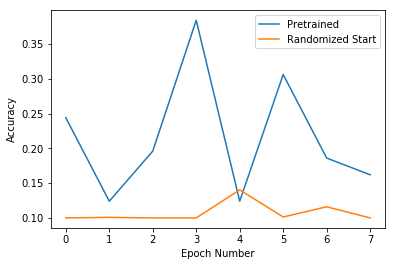

In [29]:
fig, ax = plt.subplots()

ax.plot(pretrained_history.epoch, pretrained_history.history['val_acc'], label='Pretrained')
ax.plot(random_history.epoch, random_history.history['val_acc'], label='Randomized Start')

ax.legend()
ax.set_xlabel('Epoch Number')
ax.set_ylabel('Accuracy')

## How much did the models change?


Calculate the change in the models between the weights in each layer before and after training

In [30]:
pretrained_end = get_weights_resnet(pretrained)

In [31]:
pretrained_end['change'] = (pretrained_end['weights'] - pretrained_start['weights']).apply(lambda x: np.linalg.norm(x))

In [32]:
random_weights_end = get_weights_resnet(random_start)

In [33]:
random_weights_end['change'] = (random_weights_end['weights'] 
                                - random_weights_start['weights']).apply(lambda x: np.linalg.norm(x))

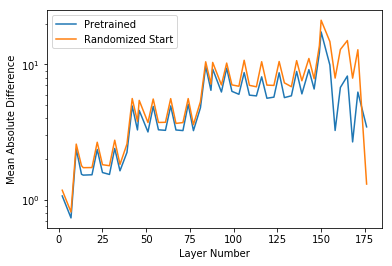

In [34]:
fig, ax = plt.subplots()

ax.semilogy(pretrained_end['layer'], pretrained_end['change'], label='Pretrained')
ax.semilogy(random_weights_end['layer'], random_weights_end['change'], label='Randomized Start')

ax.legend()
ax.set_xlabel('Layer Number')
ax.set_ylabel('Mean Absolute Difference')

There is slightly more change in the randomized start network than the initial randomized. 

Note (WardLT): I'm not sure how much this means. But, I am curious!

## Still Curious?
Try changing the amount of training data that your model uses. How does the effect of transfer learning change with more or less data? Test out different [pretrained models](https://keras.io/applications/). Are some better or worse for the CIFAR data?